In [1]:
import pandas as pd 
import numpy as np 

In [2]:

df  = pd.read_csv("D:\personal Projects\classical ML\gr.noida rent prediction (web scrapping)\greater_noida_rents_massive.csv")
df.head()

,BHK,Price,Location,Area,Furnishing,Tenant_Pref,Full_Title,Page_Found
0,2 BHK,"₹17,000 /month",Mahagun Mywoods Phase 1,850 sqft(79 sqm),NaN,Not Specified,"2 BHK Flat for rent in Sector 16C, Greater Noida",1
1,3 BHK,"₹35,000 /month",ACE Divino,"1,565 sqft(145 sqm)",NaN,Not Specified,3 BHK Flat for rent in Noida Extension,1
2,2 BHK,"₹25,000 /month",Ace City,"1,080 sqft(100 sqm)",NaN,Not Specified,2 BHK Flat for rent in Sector 1 Greater Noida ...,1
3,2 BHK,"₹25,000 /month",C block,"1,615 sqft(150 sqm)",Furnished,Not Specified,2 BHK Independent Builder Floor for rent in Si...,1
4,NaN,"₹55,000 /month",Panchsheel Villas,"1,080 sqft(100 sqm)",Furnished,Not Specified,"5 Bedroom House for rent in Sector 16B, Greate...",1


In [3]:
print('Shape of Data:',df.shape)
print('----'*20,'\n Data Types Info:')
print(df.info())

Shape of Data: (2526, 8)
-------------------------------------------------------------------------------- 
 Data Types Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   BHK          2293 non-null   object
 1   Price        2526 non-null   object
 2   Location     2526 non-null   object
 3   Area         2526 non-null   object
 4   Furnishing   735 non-null    object
 5   Tenant_Pref  2526 non-null   object
 6   Full_Title   2526 non-null   object
 7   Page_Found   2526 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 158.0+ KB
None


# Data Cleaning

In [4]:
print(df.isnull().sum())
print('----'*20,'\n Tenent_pref Value Counts:')
print(df['Tenant_Pref'].value_counts())

BHK             233
Price             0
Location          0
Area              0
Furnishing     1791
Tenant_Pref       0
Full_Title        0
Page_Found        0
dtype: int64
-------------------------------------------------------------------------------- 
 Tenent_pref Value Counts:
Tenant_Pref
Not Specified        2471
Family Preferred       39
Bachelors Allowed      10
Family Only             5
Boys Only               1
Name: count, dtype: int64


In [5]:
import re
import pandas as pd

# list of noisy property words that should NOT be treated as a sector/address
property_words = [
    "flat", "flats", "bhk", "bedroom", "bedrooms", "house", "independent",
    "builder floor", "floor", "studio", "apartment", "room", "rooms",
    "for rent", "rent", "sale", "residential", "resale"
]
prop_regex = r"\b(?:" + "|".join(re.escape(w) for w in property_words) + r")\b"

# 1) Primary targeted extraction for known block names / sectors (require number/letter or known word)
pattern_primary = (
    r"(Sector\s*[A-Za-z0-9]+|"
    r"Alpha\s*\w*|Beta\s*\w*|Gamma\s*\w*|Delta\s*\w*|Chi\s*\w*|"
    r"Phi\s*\w*|Omega\s*\w*|Zeta\s*\w*)"
)

df['Sector'] = df['Full_Title'].str.extract(pattern_primary, expand=False)

# 2) Fallback: text after "in " up to comma, parenthesis, or hyphen (most likely contains the address)
fallback = df['Full_Title'].str.extract(r"in\s+([^,()\-\n]+)", expand=False)

# 3) Fill primary NaNs with fallback
df['Sector'] = df['Sector'].fillna(fallback)

# 4) Remove property-type noise from the extracted value
df['Sector'] = (
    df['Sector']
      .astype(str)                                      # safe cast
      .str.replace(prop_regex, "", regex=True, flags=re.IGNORECASE)  # remove property words
      .str.replace(r"\b(Greater Noida|Noida|Noida Extension|Greater Noida West)\b", "", regex=True, case=False)
      .str.replace(r"[,:\-\(\)]", "", regex=True)     # remove punctuation
      .str.strip()
      .replace({"": pd.NA, "nan": pd.NA})             # empty -> NaN
)

# 5) Validation: keep only if it looks like a block/sector/address.
#    We require either:
#      - the word "Sector" OR
#      - a known block name (Alpha/Beta/Chi/...) OR
#      - at least one digit in the result (e.g. "16C", "4", "Block 12")
valid_pattern = re.compile(r"(?i)^(?:.*Sector.*|.*Alpha.*|.*Beta.*|.*Gamma.*|.*Chi.*|.*Delta.*|.*Omega.*|.*Zeta.*|.*\d.*)$")

mask_valid = df['Sector'].notna() & df['Sector'].str.match(valid_pattern)
df.loc[~mask_valid, 'Sector'] = pd.NA

# 6) Optional: tidy casing and normalize "sector" words
df['Sector'] = df['Sector'].str.replace(r"^sector\s+", "Sector ", flags=re.IGNORECASE, regex=True)
df['Sector'] = df['Sector'].str.title()

# Quick checks
print("Remaining NaNs in Sector:", df['Sector'].isnull().sum())
print("Sample extracted values (non-null):")
print(df['Sector'].dropna().unique()[:50])


Remaining NaNs in Sector: 341
Sample extracted values (non-null):
['Sector 16C' 'Sector 1' 'Sigma 4' 'Sector 16B' 'Sector 10'
 'Techzone 4  West' 'Sector 27' 'Sector Zeta' 'Sector 16' 'Sector Chi'
 'Sector 4' 'Sector' 'Sector Pi' 'Sector 2' 'Sector Xu' 'Sector P4'
 'Sector 31' 'Sector Omicron' 'Techzone 4' 'Eta 2' 'Nh 91' 'Sector Mu'
 'Delta 1' 'Sector 3' 'Alpha 2' 'Sector Phi' 'Sector 22D' 'Gamma 2'
 'Beta 1' 'Ecotech 3' 'Knowledge Park 3' 'Delta I' 'Sector P3' 'Sigma 2'
 'Site 5' 'Beta 2' 'Rho 1 Sector' 'Sector 25' 'Ecotech 1 Extension'
 'Chi Phi' 'Sigma 1' 'Delta 3' 'Sector Omega' 'Alpha 1' 'Gamma 1']


In [6]:
df.isnull().sum()

BHK             233
Price             0
Location          0
Area              0
Furnishing     1791
Tenant_Pref       0
Full_Title        0
Page_Found        0
Sector          341
dtype: int64

In [7]:
df.dropna(subset=['Sector'], inplace=True)
df.dropna(subset=['BHK'], inplace=True)
df.isnull().sum()

BHK               0
Price             0
Location          0
Area              0
Furnishing     1529
Tenant_Pref       0
Full_Title        0
Page_Found        0
Sector            0
dtype: int64

In [8]:
df.head()


,BHK,Price,Location,Area,Furnishing,Tenant_Pref,Full_Title,Page_Found,Sector
0,2 BHK,"₹17,000 /month",Mahagun Mywoods Phase 1,850 sqft(79 sqm),NaN,Not Specified,"2 BHK Flat for rent in Sector 16C, Greater Noida",1,Sector 16C
2,2 BHK,"₹25,000 /month",Ace City,"1,080 sqft(100 sqm)",NaN,Not Specified,2 BHK Flat for rent in Sector 1 Greater Noida ...,1,Sector 1
3,2 BHK,"₹25,000 /month",C block,"1,615 sqft(150 sqm)",Furnished,Not Specified,2 BHK Independent Builder Floor for rent in Si...,1,Sigma 4
5,3 BHK,"₹21,000 /month",Arihant Abode,"1,160 sqft(108 sqm)",NaN,Not Specified,3 BHK Flat for rent in Sector 10 Greater Noida...,1,Sector 10
6,4 BHK,"₹26,000 /month",La Residentia,"1,538 sqft(143 sqm)",Semi-Furnished,Not Specified,4 BHK Flat for rent in Techzone 4 Greater Noid...,1,Techzone 4 West


In [9]:
cols_to_drop = [
    'Location',
    'Furnishing',
    'Tenant_Pref',
    'Full_Title',
    'Page_Found'
]

df = df.drop(columns=cols_to_drop, errors='ignore')
df.head()

,BHK,Price,Area,Sector
0,2 BHK,"₹17,000 /month",850 sqft(79 sqm),Sector 16C
2,2 BHK,"₹25,000 /month","1,080 sqft(100 sqm)",Sector 1
3,2 BHK,"₹25,000 /month","1,615 sqft(150 sqm)",Sigma 4
5,3 BHK,"₹21,000 /month","1,160 sqft(108 sqm)",Sector 10
6,4 BHK,"₹26,000 /month","1,538 sqft(143 sqm)",Techzone 4 West


In [10]:
# Changing BHK col into int
df['BHK'] = df['BHK'].str.extract(r'(\d+)').astype(int)

#changing Price Col into Int
df['Price (Rupee)'] = (
    df['Price']
    .str.replace('₹', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.extract(r'(\d+)')[0]
    .astype(int)
)
# changing Area col into int
# FIX for Cell 10
# Remove commas first, then extract
df['Area_sqft'] = df['Area'].str.replace(',', '').str.extract(r'(\d+)\s*sqft')[0].astype(int)

#dropping original cols
cols_to_drop2 = [
    'Price',
    'Area'   
]
# dropping original cols
df = df.drop(columns=cols_to_drop2, errors='ignore')
df.head()


,BHK,Sector,Price (Rupee),Area_sqft
0,2,Sector 16C,17000,850
2,2,Sector 1,25000,1080
3,2,Sigma 4,25000,1615
5,3,Sector 10,21000,1160
6,4,Techzone 4 West,26000,1538


In [11]:
print(df.info())
print('---'*20,)
print('\n count of catagory in Sector Column is' , len(df['Sector'].unique()))

<class 'pandas.core.frame.DataFrame'>
Index: 2007 entries, 0 to 2525
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   BHK            2007 non-null   int32 
 1   Sector         2007 non-null   object
 2   Price (Rupee)  2007 non-null   int32 
 3   Area_sqft      2007 non-null   int32 
dtypes: int32(3), object(1)
memory usage: 54.9+ KB
None
------------------------------------------------------------

 count of catagory in Sector Column is 32


In [12]:
df['Sector'].unique()

array(['Sector 16C', 'Sector 1', 'Sigma 4', 'Sector 10',
       'Techzone 4  West', 'Sector 27', 'Sector 16', 'Sector Zeta',
       'Sector 16B', 'Sector Chi', 'Sector 4', 'Sector', 'Sector Pi',
       'Sector 2', 'Sector Xu', 'Sector P4', 'Sector 31',
       'Sector Omicron', 'Techzone 4', 'Eta 2', 'Sector Mu', 'Sector 3',
       'Alpha 2', 'Sector Phi', 'Ecotech 3', 'Gamma 2', 'Sector 22D',
       'Sigma 2', 'Beta 1', 'Beta 2', 'Rho 1 Sector', 'Sector 25'],
      dtype=object)

# Feature Engineering

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

In [14]:
# Create Logic Features (Ratios)
# Helps model understand "Crowding" (Area per room)
df['Area_per_BHK'] = df['Area_sqft'] / df['BHK']

# Log Transform the Target (Crucial for Accuracy)
# Predict log_price instead of raw price to handle skewness
df['Log_Price'] = np.log1p(df['Price (Rupee)'])

In [15]:
# "Luxury Score" = Area * BHK (Combines size and rooms into one metric)
df['Luxury_Score'] = df['Area_sqft'] * df['BHK']

# "Log_Area" = Helps model see percentage differences in size better
df['Log_Area'] = np.log1p(df['Area_sqft'])

In [16]:
df.head()

,BHK,Sector,Price (Rupee),Area_sqft,Area_per_BHK,Log_Price,Luxury_Score,Log_Area
0,2,Sector 16C,17000,850,425.000000,9.741027,1700,6.746412
2,2,Sector 1,25000,1080,540.000000,10.126671,2160,6.985642
3,2,Sigma 4,25000,1615,807.500000,10.126671,3230,7.387709
5,3,Sector 10,21000,1160,386.666667,9.952325,3480,7.057037
6,4,Techzone 4 West,26000,1538,384.500000,10.165890,6152,7.338888


# Preprocessing

In [18]:
# Split Data (Before Encoding to prevent leakage)
X = df[['BHK', 'Area_sqft', 'Sector', 'Area_per_BHK', 'Luxury_Score', 'Log_Area']]
y = df['Log_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Target Encoding (The "Safe" Way)
# Compute means on TRAIN only, map to Test
sector_means = X_train.join(y_train).groupby('Sector')['Log_Price'].mean()
global_mean = y_train.mean()

X_train['Sector_Encoded'] = X_train['Sector'].map(sector_means).fillna(global_mean)
X_test['Sector_Encoded'] = X_test['Sector'].map(sector_means).fillna(global_mean)

In [20]:
# Drop raw text column
X_train = X_train.drop(columns=['Sector'])
X_test = X_test.drop(columns=['Sector'])

In [21]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
X_train_scaled

array([[ 0.63350178, -0.19918256, -0.45320184, -0.05718386, -0.21932926,
         0.0666329 ],
       [ 2.25256286,  0.722977  , -0.11497182,  1.42880892,  1.37131736,
         2.72194012],
       [-0.9855593 , -0.4523244 , -0.11497182, -0.61902565, -0.84209174,
        -0.52899032],
       ...,
       [ 0.63350178, -0.06658445, -0.31912867,  0.05833501,  0.06411189,
        -0.52899032],
       [-0.9855593 , -0.48848752, -0.16981993, -0.64002908, -0.94185958,
        -1.04438829],
       [-0.9855593 , -0.43424284, -0.08754776, -0.60852394, -0.79335205,
        -1.04438829]])

# Model tranning

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Import Metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

#Define the 6 Models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.001, random_state=42), # Low alpha for log-data
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, n_jobs=-1, random_state=42)
}

In [24]:
#Training Loop
results = []

print("Training & Evaluating Models...")
print("-" * 60)
for name, model in models.items():
    # Train on Scaled Data
    model.fit(X_train_scaled, y_train)
    
    # Predict (Output is still Log Price)
    y_pred_log = model.predict(X_test_scaled)
    
    # Inverse Transform: Convert Log Price back to Rupees
    y_pred_actual = np.expm1(y_pred_log)
    y_test_actual = np.expm1(y_test)
    
    # Calculate Metrics on Actual Prices
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    r2 = r2_score(y_test_actual, y_pred_actual)
    
    # Save Results
    results.append({
        "Model": name,
        "MAE (₹)": mae,
        "RMSE (₹)": rmse,
        "R² Score": r2
    })
    
    print(f"{name:<20} | R²: {r2:.4f} | MAE: ₹{mae:,.0f}")

Training & Evaluating Models...
------------------------------------------------------------
Linear Regression    | R²: 0.2969 | MAE: ₹3,651
Lasso Regression     | R²: 0.5029 | MAE: ₹3,590
Ridge Regression     | R²: 0.3831 | MAE: ₹3,622
Decision Tree        | R²: 0.6738 | MAE: ₹2,887
Random Forest        | R²: 0.6772 | MAE: ₹2,813
XGBoost              | R²: 0.6992 | MAE: ₹2,813


------------------------------------------------------------

FINAL LEADERBOARD (Sorted by Accuracy):
               Model      MAE (₹)     RMSE (₹)  R² Score
5            XGBoost  2813.380145  4253.620405  0.699234
4      Random Forest  2813.250740  4406.838513  0.677176
3      Decision Tree  2886.966176  4430.103299  0.673758
1   Lasso Regression  3589.523633  5468.418175  0.502910
2   Ridge Regression  3622.098426  6091.730099  0.383131
0  Linear Regression  3650.743542  6503.785407  0.296856


C:\Users\singh\AppData\Local\Temp\ipykernel_16780\4141779558.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=leaderboard, x="R² Score", y="Model", palette="viridis")


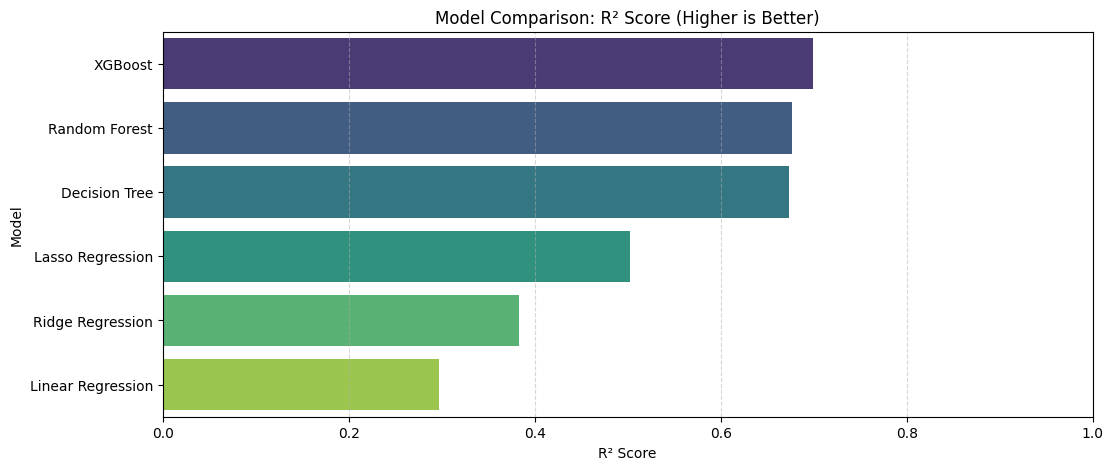

In [25]:
#Create Leaderboard
leaderboard = pd.DataFrame(results).sort_values(by="R² Score", ascending=False)

print("-" * 60)
print("\nFINAL LEADERBOARD (Sorted by Accuracy):")
print(leaderboard)

# 4. Visualization
plt.figure(figsize=(12, 5))
sns.barplot(data=leaderboard, x="R² Score", y="Model", palette="viridis")
plt.title("Model Comparison: R² Score (Higher is Better)")
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
# Define the Parameter Grid
# These are the "knobs" we will turn to find the best combination
param_grid = {
    'n_estimators': [500, 1000, 1500],      # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # How fast the model learns
    'max_depth': [3, 5, 7],                 # Maximum depth of a tree
    'subsample': [0.7, 0.8],                # Fraction of samples used per tree
    'colsample_bytree': [0.7, 0.8]          # Fraction of features used per tree
}

# Initialize K-Fold Cross-Validator
# n_splits=5 means we use 5-Fold CV (80% train / 20% validation inside the training set)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

#Setup GridSearchCV
# This will run K-Fold CV for EVERY combination in param_grid
print("Starting Hyperparameter Tuning... (This may take a minute)")
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',             # We want to maximize R² Score
    cv=kfold,                 # Use our 5-Fold split
    n_jobs=-1,                # Use all CPU cores
    verbose=1                 # Show progress
)

# Fit the Search

grid_search.fit(X_train_scaled, y_train)

# Get Best Results
best_model = grid_search.best_estimator_
print("\nBest Parameters Found:")
print(grid_search.best_params_)
print(f"Best CV Score (R²): {grid_search.best_score_:.4f}")

Starting Hyperparameter Tuning... (This may take a minute)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters Found:
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.8}
Best CV Score (R²): 0.6861


In [27]:
# Final Evaluation on Test Set (Unseen Data)
y_pred_log = best_model.predict(X_test_scaled)

# Convert back to Rupees
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

In [28]:
# Metrics
from sklearn.metrics import r2_score, mean_absolute_error
final_r2 = r2_score(y_test_actual, y_pred_actual)
final_mae = mean_absolute_error(y_test_actual, y_pred_actual)

print("-" * 30)
print(f"Final Tuned Model Performance:")
print(f"R² Score: {final_r2:.4f}")
print(f"MAE: ₹{final_mae:,.0f}")
print("-" * 30)

------------------------------
Final Tuned Model Performance:
R² Score: 0.7007
MAE: ₹2,820
------------------------------


C:\Users\singh\AppData\Local\Temp\ipykernel_16780\4210177661.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance', y='Feature', palette='viridis')


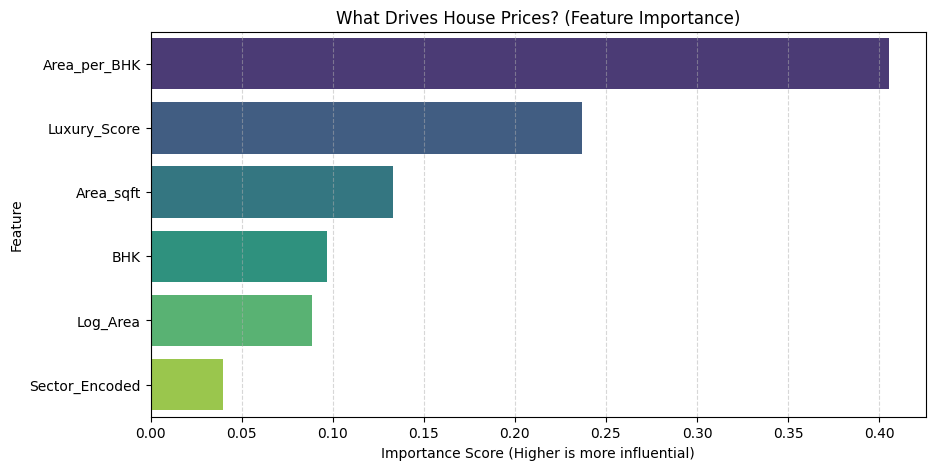

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importance from the best model
# If you used GridSearchCV, use 'best_model'. If just XGBoost, use 'model'
importance = best_model.feature_importances_
feature_names = ['BHK', 'Area_sqft', 'Sector_Encoded', 'Area_per_BHK', 'Luxury_Score', 'Log_Area']

# Create a DataFrame for better visualization
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=fi_df, x='Importance', y='Feature', palette='viridis')

plt.title("What Drives House Prices? (Feature Importance)")
plt.xlabel("Importance Score (Higher is more influential)")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()